In [10]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from sphere_initialization import generate_class_vectors
from sphere_initialization import generate_class_vectors_hemispheres
from siglip_loss import SigLIPLoss
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
torch.manual_seed(50)

n_classes = 100
dim = 3
n_epochs = int(5e4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generate initial class vectors
U_init, V_init = generate_class_vectors(n_classes, dim, device)

# Make U and V learnable parameters and project them onto the unit sphere
U = nn.Parameter(U_init / torch.norm(U_init, dim=1, keepdim=True))
V = nn.Parameter(V_init / torch.norm(V_init, dim=1, keepdim=True))

# Initialize SigLIP loss with trainable temperature and bias
criterion = SigLIPLoss(temperature=10.0, relative_bias=0.1, trainable_bias=False).to(device)

# Create optimizer for U and V vectors
optimizer = torch.optim.Adam([
    {'params': U, 'lr': 0.01},
    {'params': V, 'lr': 0.01},
    {'params': criterion.parameters(), 'lr': 0.01}
])

# Training loop
losses = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = criterion(U, V)
    loss.backward()
    optimizer.step()
    
    # Project U and V back onto the unit sphere after optimization
    with torch.no_grad():
        U.data = U.data / torch.norm(U.data, dim=1, keepdim=True)
        V.data = V.data / torch.norm(V.data, dim=1, keepdim=True)
    
    # Store loss
    losses.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, '
              f'Temperature: {criterion.get_temperature():.4f}, '
              f'Relative bias: {criterion.get_bias():.4f}')

Epoch [100/50000], Loss: 0.1092, Temperature: 5.9947, Relative bias: 0.1000
Epoch [200/50000], Loss: 0.0528, Temperature: 6.1377, Relative bias: 0.1000
Epoch [300/50000], Loss: 0.0482, Temperature: 6.2940, Relative bias: 0.1000
Epoch [400/50000], Loss: 0.0462, Temperature: 6.4832, Relative bias: 0.1000
Epoch [500/50000], Loss: 0.0449, Temperature: 6.7000, Relative bias: 0.1000
Epoch [600/50000], Loss: 0.0440, Temperature: 6.9469, Relative bias: 0.1000
Epoch [700/50000], Loss: 0.0434, Temperature: 7.2203, Relative bias: 0.1000
Epoch [800/50000], Loss: 0.0429, Temperature: 7.5170, Relative bias: 0.1000
Epoch [900/50000], Loss: 0.0424, Temperature: 7.8383, Relative bias: 0.1000
Epoch [1000/50000], Loss: 0.0419, Temperature: 8.1860, Relative bias: 0.1000
Epoch [1100/50000], Loss: 0.0415, Temperature: 8.5618, Relative bias: 0.1000
Epoch [1200/50000], Loss: 0.0410, Temperature: 8.9677, Relative bias: 0.1000
Epoch [1300/50000], Loss: 0.0406, Temperature: 9.4064, Relative bias: 0.1000
Epoch [1

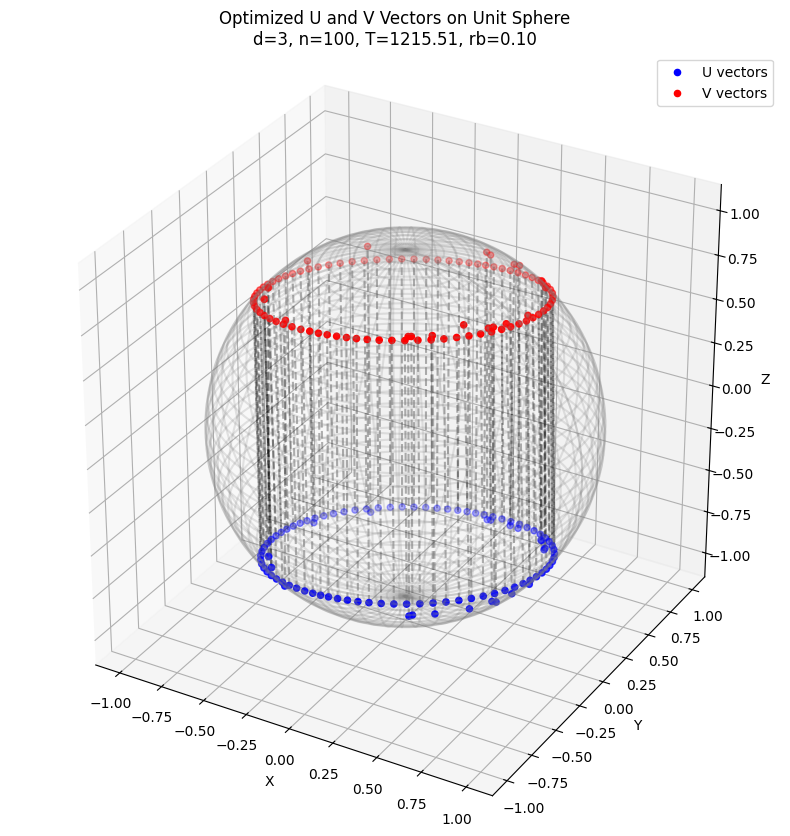

In [ ]:
def plot_optimized_vectors(U, V, n_classes, criterion):
    """
    Plot the optimized U and V vectors on a unit sphere.

    Args:
        U (torch.Tensor): Tensor of U vectors of shape [n_classes, dim].
        V (torch.Tensor): Tensor of V vectors of shape [n_classes, dim].
        n_classes (int): Number of classes (or pairs of vectors).
        criterion (SigLIPLoss): The loss function to get final temperature and bias.
    """
    # Create a figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Move vectors to CPU and convert to numpy for plotting
    U_np = U.detach().cpu().numpy()
    V_np = V.detach().cpu().numpy()

    # Plot the unit sphere wireframe
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.2)

    # Plot the points
    ax.scatter(U_np[:, 0], U_np[:, 1], U_np[:, 2], c='blue', label='U vectors')
    ax.scatter(V_np[:, 0], V_np[:, 1], V_np[:, 2], c='red', label='V vectors')

    # Draw lines between corresponding U and V vectors
    for i in range(n_classes):
        ax.plot([U_np[i, 0], V_np[i, 0]], 
                [U_np[i, 1], V_np[i, 1]], 
                [U_np[i, 2], V_np[i, 2]], 'k--', alpha=0.3)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Create title with additional information
    dim = U.shape[1]
    temp = criterion.get_temperature()
    relative_bias = criterion.get_bias()
    title = f'Optimized U and V Vectors on Unit Sphere\n'
    title += f'd={dim}, n={n_classes}, T={temp:.2f}, rb={relative_bias:.2f}'
    ax.set_title(title)
    
    ax.legend()

    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

    plt.show()

plot_optimized_vectors(U, V, n_classes, criterion)

In [4]:
# Compute inner products between all pairs of U and V vectors
inner_products = torch.matmul(U, V.T)

print("Inner products matrix:")
print(inner_products)

# Check diagonal elements (corresponding pairs)
diagonal = torch.diagonal(inner_products)
print("\nInner products for corresponding pairs (u_i · v_i):")
print(diagonal)
print(f"Mean inner product for corresponding pairs: {diagonal.mean():.4f}")

# Check off-diagonal elements (non-corresponding pairs)
mask = ~torch.eye(n_classes, dtype=bool)
off_diagonal = inner_products[mask]
print("\nInner products for non-corresponding pairs (u_i · v_j where i≠j):")
print(off_diagonal)
print(f"Mean inner product for non-corresponding pairs: {off_diagonal.mean():.4f}")

# Test the hypothesis
positive_diagonal = (diagonal > 0).all()
negative_off_diagonal = (off_diagonal < 0).all()

print("\nHypothesis test results:")
print(f"All corresponding pairs have positive inner product: {positive_diagonal}")
print(f"All non-corresponding pairs have negative inner product: {negative_off_diagonal}")


Inner products matrix:
tensor([[-0.0484, -0.0463, -0.3189,  ..., -0.0239, -0.7831, -0.0570],
        [-0.0484, -0.0462, -0.3165,  ..., -0.0256, -0.7808, -0.0559],
        [-0.2150, -0.2113,  0.1006,  ..., -0.4911, -0.1514, -0.0204],
        ...,
        [-0.0665, -0.0655, -0.5193,  ...,  0.1002, -0.9334, -0.1623],
        [-0.7814, -0.7790, -0.2809,  ..., -0.9504, -0.0586, -0.5995],
        [ 0.0048,  0.0081, -0.0141,  ..., -0.1466, -0.4803,  0.1008]],
       grad_fn=<MmBackward0>)

Inner products for corresponding pairs (u_i · v_i):
tensor([-0.0484, -0.0462,  0.1006,  0.0038,  0.1006,  0.1008, -0.0222,  0.1002,
        -0.0519, -0.0556,  0.1006,  0.1007, -0.0811,  0.0995,  0.1007,  0.1007,
         0.1003,  0.1006,  0.1001,  0.1007,  0.1008,  0.0173,  0.1004,  0.1004,
         0.1007,  0.1005,  0.1013,  0.1006, -0.0269,  0.1009,  0.1008,  0.1006,
         0.1007,  0.1005,  0.1004,  0.0088,  0.1009,  0.1003,  0.1003, -0.0070,
         0.1009,  0.1003,  0.1010,  0.1002,  0.1005, -0.0726

In [14]:
def train_siglip(relative_bias, n_classes=100, dim=3, n_epochs=int(5e4)):
    """Train SigLIP with a specific relative bias"""
    print(f"\nTraining with relative_bias = {relative_bias}")
    
    # Generate initial class vectors
    U_init, V_init = generate_class_vectors(n_classes, dim, device)

    # Make U and V learnable parameters and project them onto the unit sphere
    U = nn.Parameter(U_init / torch.norm(U_init, dim=1, keepdim=True))
    V = nn.Parameter(V_init / torch.norm(V_init, dim=1, keepdim=True))

    # Initialize SigLIP loss with trainable temperature and specified bias
    criterion = SigLIPLoss(temperature=10.0, relative_bias=relative_bias, trainable_bias=False).to(device)

    # Create optimizer for U and V vectors
    optimizer = torch.optim.Adam([
        {'params': U, 'lr': 0.01},
        {'params': V, 'lr': 0.01},
        {'params': criterion.parameters(), 'lr': 0.01}
    ])

    # Training loop
    losses = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = criterion(U, V)
        loss.backward()
        optimizer.step()
        
        # Project U and V back onto the unit sphere after optimization
        with torch.no_grad():
            U.data = U.data / torch.norm(U.data, dim=1, keepdim=True)
            V.data = V.data / torch.norm(V.data, dim=1, keepdim=True)
        
        # Store loss
        losses.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, '
                  f'Temperature: {criterion.get_temperature():.4f}, '
                  f'Relative bias: {criterion.get_bias():.4f}')

    return U, V, criterion, losses

In [23]:
def plot_loss_curves(all_losses, relative_biases):
    """Plot loss curves for all experiments"""
    plt.figure(figsize=(12, 6))
    
    for i, rb in enumerate(relative_biases):
        plt.plot(all_losses[i], label=f'Relative Bias = {rb}')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss for Different Relative Bias Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('siglip_loss_curves.png', dpi=300)
    plt.show()

def plot_optimized_vectors(U, V, n_classes, criterion, ax=None):
    """Plot the optimized U and V vectors on a unit sphere"""
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
    
    # Move vectors to CPU and convert to numpy for plotting
    U_np = U.detach().cpu().numpy()
    V_np = V.detach().cpu().numpy()

    # Plot the unit sphere wireframe
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.1)

    # Plot the points
    ax.scatter(U_np[:, 0], U_np[:, 1], U_np[:, 2], c='blue', s=20, label='U vectors')
    ax.scatter(V_np[:, 0], V_np[:, 1], V_np[:, 2], c='red', s=20, label='V vectors')

    # Draw lines between corresponding U and V vectors
    for i in range(n_classes):
        ax.plot([U_np[i, 0], V_np[i, 0]], 
                [U_np[i, 1], V_np[i, 1]], 
                [U_np[i, 2], V_np[i, 2]], 'k--', alpha=0.2)

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Create title with additional information
    dim = U.shape[1]
    temp = criterion.get_temperature()
    relative_bias = criterion.get_bias()
    title = f'rb={relative_bias:.2f}, T={temp:.2f}'
    ax.set_title(title)
    
    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    return ax

def plot_all_results(all_results, relative_biases, n_classes):
    """Create a comprehensive visualization of all results"""
    fig = plt.figure(figsize=(18, 12))
    
    # Create GridSpec with more spacing
    gs = GridSpec(3, 3, figure=fig, wspace=0.3, hspace=0.4)
    
    # Plot individual sphere plots
    for i, rb in enumerate(relative_biases):
        row, col = i // 3, i % 3
        ax = fig.add_subplot(gs[row, col], projection='3d')
        U, V, criterion, _ = all_results[i]
        plot_optimized_vectors(U, V, n_classes, criterion, ax)
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
    
    # Add a common legend
    fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)
    
    fig.suptitle('Optimized Vectors for Different Relative Bias Values', fontsize=18)
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.05, right=0.95)
    plt.savefig('siglip_all_vectors.png', dpi=300)
    plt.show()

def calculate_margin(U, V):
    """
    Calculate the margin between matching and non-matching pairs.
    
    Margin is defined as the difference between:
    - The minimum similarity between matching pairs (U_i, V_i)
    - The maximum similarity between non-matching pairs (U_i, V_j) where i != j
    """
    # Calculate all pairwise cosine similarities
    cosine_sim = torch.matmul(U, V.t())  # [n_classes, n_classes]
    
    # Get diagonals (matching pairs)
    diag_indices = torch.arange(U.shape[0], device=U.device)
    matching_sims = cosine_sim[diag_indices, diag_indices]
    min_matching_sim = torch.min(matching_sims).item()
    
    # Create a mask to exclude diagonal elements
    mask = torch.ones_like(cosine_sim, dtype=torch.bool)
    mask[diag_indices, diag_indices] = False
    
    # Get maximum non-matching similarity
    non_matching_sims = cosine_sim[mask]
    max_non_matching_sim = torch.max(non_matching_sims).item()
    
    # Calculate margin
    margin = (min_matching_sim - max_non_matching_sim)/2
    
    return margin, min_matching_sim, max_non_matching_sim

def analyze_angles_and_margins(all_results, relative_biases):
    """Analyze angles between corresponding vectors and margins"""
    avg_angles = []
    margins = []
    min_matching_sims = []
    max_non_matching_sims = []
    
    for U, V, _, _ in all_results:
        # Calculate angles
        U_np = U.detach().cpu().numpy()
        V_np = V.detach().cpu().numpy()
        cos_sims = np.sum(U_np * V_np, axis=1)
        angles = np.arccos(np.clip(cos_sims, -1.0, 1.0)) * 180 / np.pi
        avg_angles.append(np.mean(angles))
        
        # Calculate margin
        margin, min_match, max_non_match = calculate_margin(U, V)
        margins.append(margin)
        min_matching_sims.append(min_match)
        max_non_matching_sims.append(max_non_match)
    
    # Plot average angles
    plt.figure(figsize=(10, 6))
    plt.plot(relative_biases, avg_angles, 'o-', linewidth=2)
    plt.xlabel('Relative Bias')
    plt.ylabel('Average Angle (degrees)')
    plt.title('Average Angle Between Corresponding U and V Vectors')
    plt.grid(True)
    plt.savefig('siglip_average_angles.png', dpi=300)
    plt.show()
    
    # Plot margins
    plt.figure(figsize=(10, 6))
    plt.plot(relative_biases, margins, 'o-', linewidth=2, color='green')
    plt.xlabel('Relative Bias')
    plt.ylabel('Margin')
    plt.title('Margin Between Matching and Non-matching Pairs')
    plt.grid(True)
    plt.savefig('siglip_margins.png', dpi=300)
    plt.show()
    
    # Plot similarity values
    plt.figure(figsize=(12, 6))
    plt.plot(relative_biases, min_matching_sims, 'o-', linewidth=2, label='Min Matching Similarity')
    plt.plot(relative_biases, max_non_matching_sims, 'o-', linewidth=2, label='Max Non-matching Similarity')
    plt.fill_between(relative_biases, min_matching_sims, max_non_matching_sims, alpha=0.2, color='green', label='Margin')
    plt.xlabel('Relative Bias')
    plt.ylabel('Cosine Similarity')
    plt.title('Similarity Values and Margins')
    plt.legend()
    plt.grid(True)
    plt.savefig('siglip_similarities.png', dpi=300)
    plt.show()
    
    # Print the results
    print("\nAverage angles between corresponding U and V vectors:")
    for rb, angle in zip(relative_biases, avg_angles):
        print(f"Relative bias = {rb}: {angle:.2f} degrees")
        
    print("\nMargins between matching and non-matching pairs:")
    for rb, margin, min_match, max_non_match in zip(relative_biases, margins, min_matching_sims, max_non_matching_sims):
        print(f"Relative bias = {rb}: Margin = {margin:.4f} (Min match: {min_match:.4f}, Max non-match: {max_non_match:.4f})")



Training with relative_bias = -0.3
Epoch [1000/10000], Loss: 0.0158, Temperature: 17.1724, Relative bias: -0.3000
Epoch [2000/10000], Loss: 0.0012, Temperature: 38.0973, Relative bias: -0.3000
Epoch [3000/10000], Loss: 0.0002, Temperature: 50.7034, Relative bias: -0.3000
Epoch [4000/10000], Loss: 0.0001, Temperature: 59.4448, Relative bias: -0.3000
Epoch [5000/10000], Loss: 0.0000, Temperature: 66.5155, Relative bias: -0.3000
Epoch [6000/10000], Loss: 0.0000, Temperature: 72.7189, Relative bias: -0.3000
Epoch [7000/10000], Loss: 0.0000, Temperature: 78.4223, Relative bias: -0.3000
Epoch [8000/10000], Loss: 0.0000, Temperature: 83.8162, Relative bias: -0.3000
Epoch [9000/10000], Loss: 0.0000, Temperature: 89.0076, Relative bias: -0.3000
Epoch [10000/10000], Loss: 0.0000, Temperature: 94.0573, Relative bias: -0.3000

Training with relative_bias = -0.1
Epoch [1000/10000], Loss: 0.0034, Temperature: 23.2039, Relative bias: -0.1000
Epoch [2000/10000], Loss: 0.0003, Temperature: 38.0797, Re

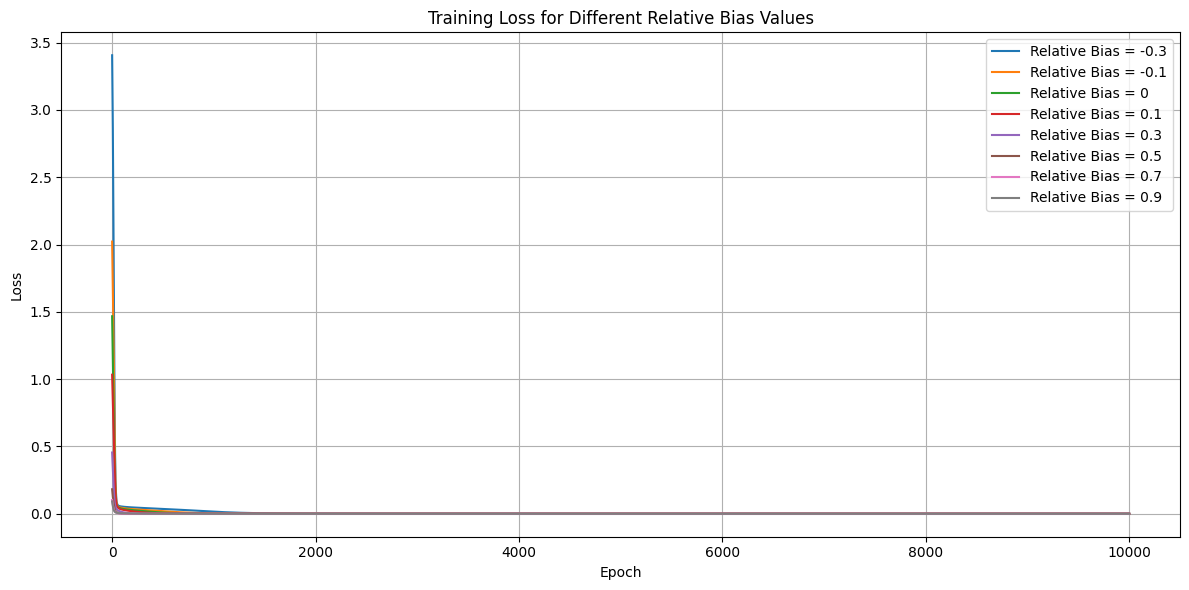

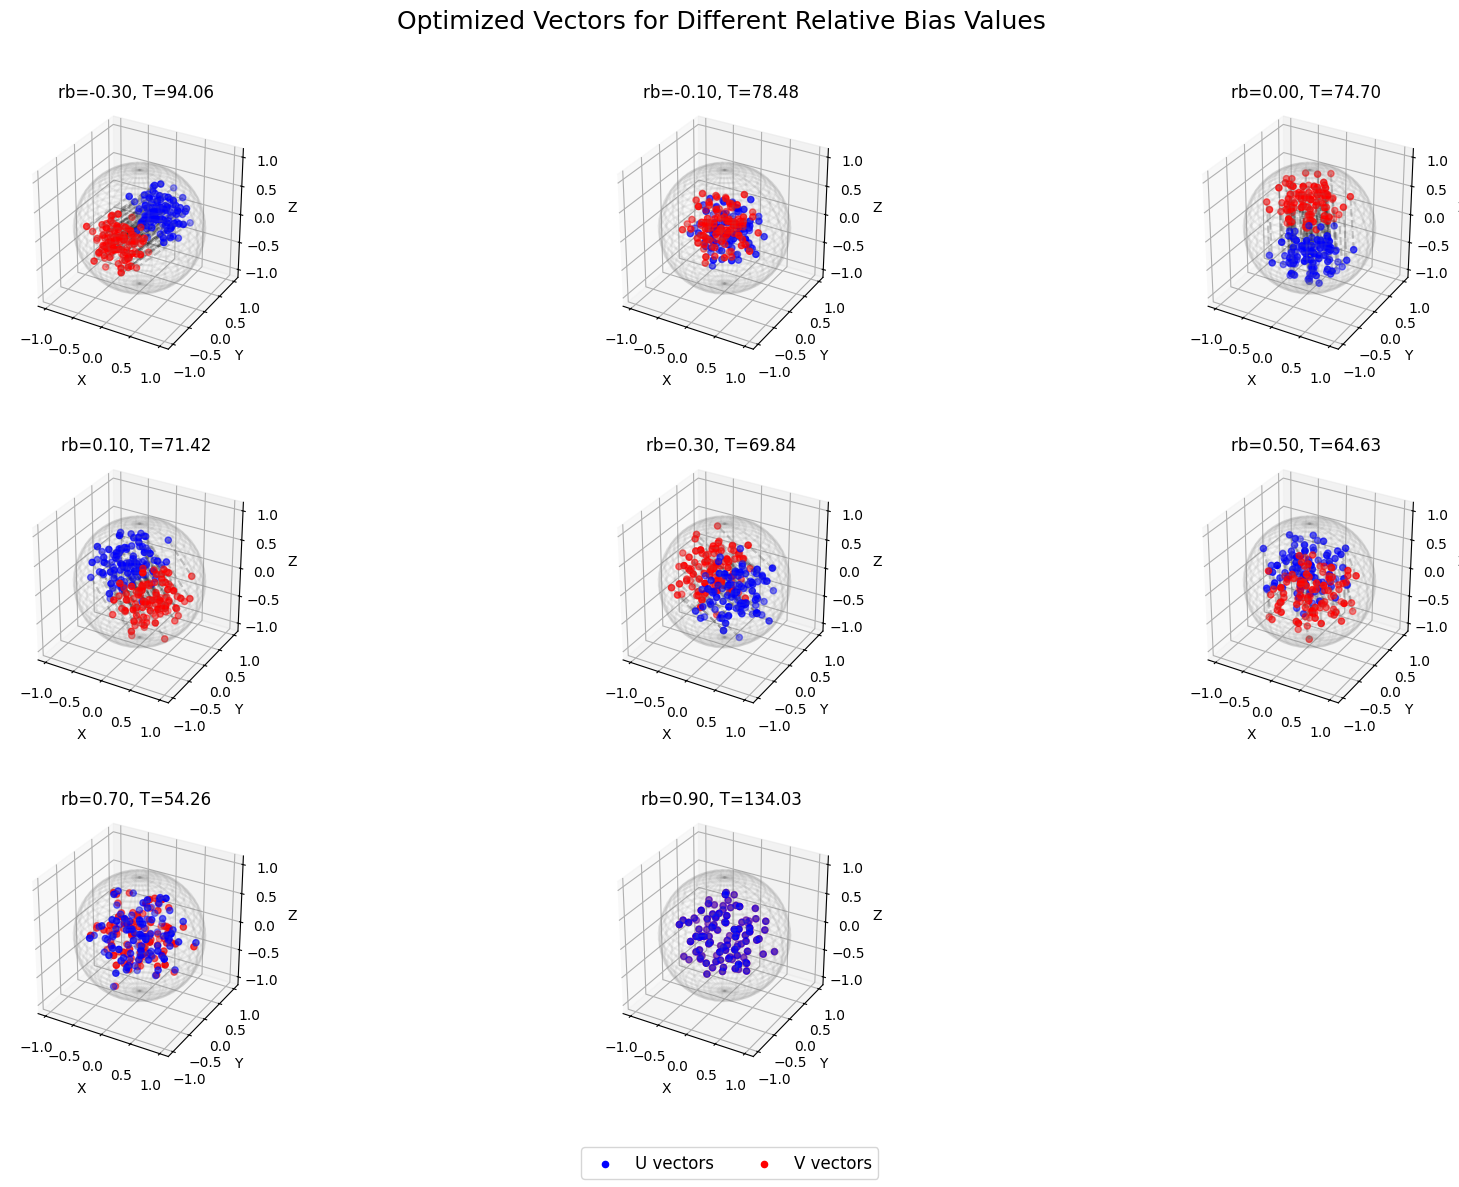

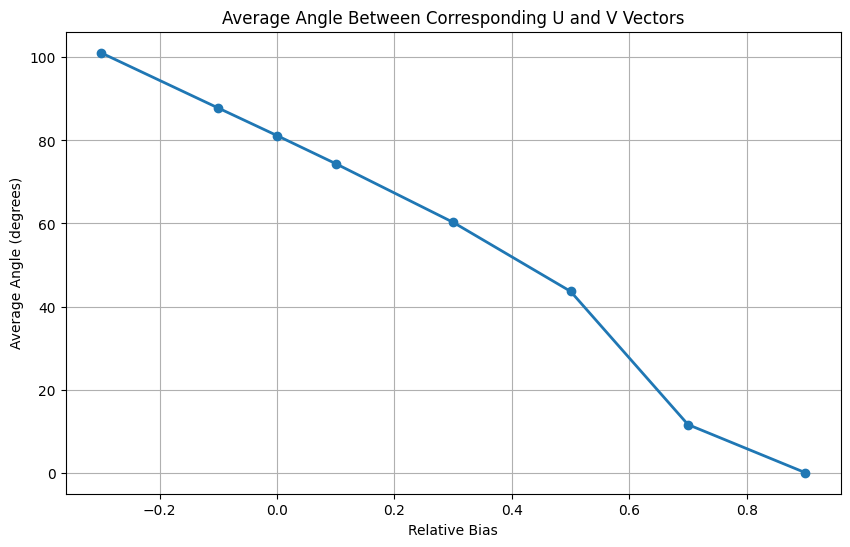

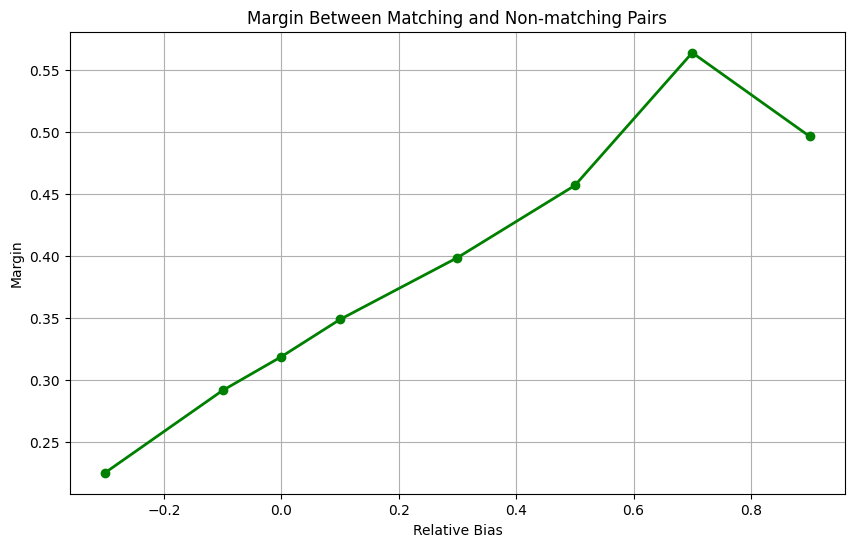

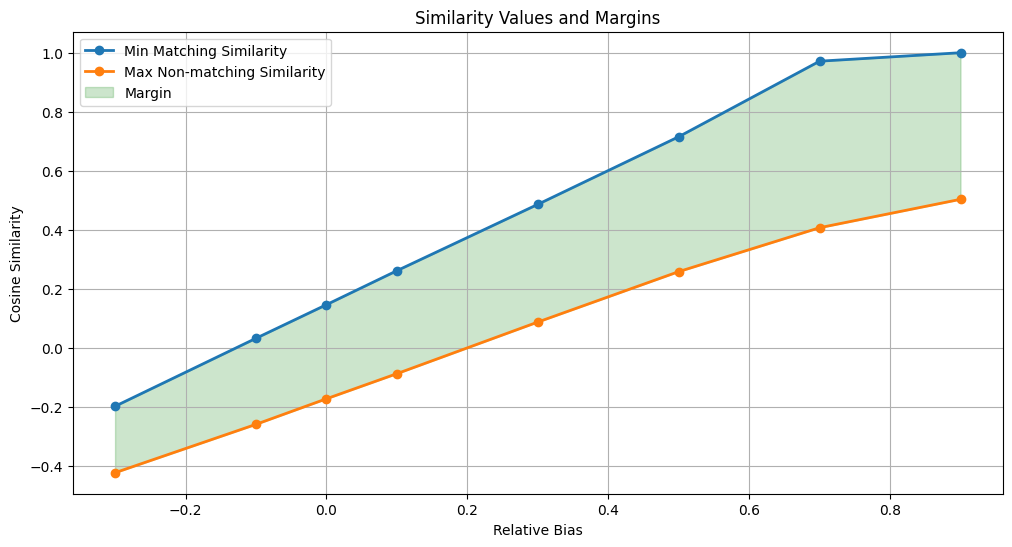


Average angles between corresponding U and V vectors:
Relative bias = -0.3: 101.11 degrees
Relative bias = -0.1: 87.79 degrees
Relative bias = 0: 81.16 degrees
Relative bias = 0.1: 74.40 degrees
Relative bias = 0.3: 60.27 degrees
Relative bias = 0.5: 43.66 degrees
Relative bias = 0.7: 11.59 degrees
Relative bias = 0.9: 0.00 degrees

Margins between matching and non-matching pairs:
Relative bias = -0.3: Margin = 0.2249 (Min match: -0.1968, Max non-match: -0.4217)
Relative bias = -0.1: Margin = 0.2913 (Min match: 0.0333, Max non-match: -0.2580)
Relative bias = 0: Margin = 0.3185 (Min match: 0.1470, Max non-match: -0.1714)
Relative bias = 0.1: Margin = 0.3485 (Min match: 0.2621, Max non-match: -0.0865)
Relative bias = 0.3: Margin = 0.3984 (Min match: 0.4867, Max non-match: 0.0883)
Relative bias = 0.5: Margin = 0.4566 (Min match: 0.7156, Max non-match: 0.2590)
Relative bias = 0.7: Margin = 0.5637 (Min match: 0.9713, Max non-match: 0.4076)
Relative bias = 0.9: Margin = 0.4962 (Min match: 1

In [22]:
def main():
    # Experiment parameters
    relative_biases = [-0.3, -0.1, 0, 0.1, 0.3, 0.5, 0.7, 0.9]
    n_classes = 100
    dim = 10
    n_epochs = int(1e4)
    
    # Store results for each experiment
    all_results = []
    all_losses = []
    
    # Run experiments for each relative bias
    for rb in relative_biases:
        U, V, criterion, losses = train_siglip(rb, n_classes, dim, n_epochs)
        all_results.append((U, V, criterion, losses))
        all_losses.append(losses)
    
    # Visualize results
    plot_loss_curves(all_losses, relative_biases)
    plot_all_results(all_results, relative_biases, n_classes)
    analyze_angles_and_margins(all_results, relative_biases)

if __name__ == "__main__":
    main()

Running experiments with relative biases: [-1.         -0.89473684 -0.78947368 -0.68421053 -0.57894737 -0.47368421
 -0.36842105 -0.26315789 -0.15789474 -0.05263158  0.05263158  0.15789474
  0.26315789  0.36842105  0.47368421  0.57894737  0.68421053  0.78947368
  0.89473684  1.        ]

Training with relative_bias = -1.0
Epoch [1000/10000], Loss: 0.6931, Temperature: 6.5136, Relative bias: -1.0000
Epoch [2000/10000], Loss: 0.6931, Temperature: 6.5136, Relative bias: -1.0000
Epoch [3000/10000], Loss: 0.6931, Temperature: 6.5136, Relative bias: -1.0000
Epoch [4000/10000], Loss: 0.6931, Temperature: 6.5136, Relative bias: -1.0000
Epoch [5000/10000], Loss: 0.6931, Temperature: 6.5136, Relative bias: -1.0000
Epoch [6000/10000], Loss: 0.6931, Temperature: 6.5136, Relative bias: -1.0000
Epoch [7000/10000], Loss: 0.6931, Temperature: 6.5133, Relative bias: -1.0000
Epoch [8000/10000], Loss: 0.6931, Temperature: 6.5117, Relative bias: -1.0000
Epoch [9000/10000], Loss: 0.6931, Temperature: 6.5062

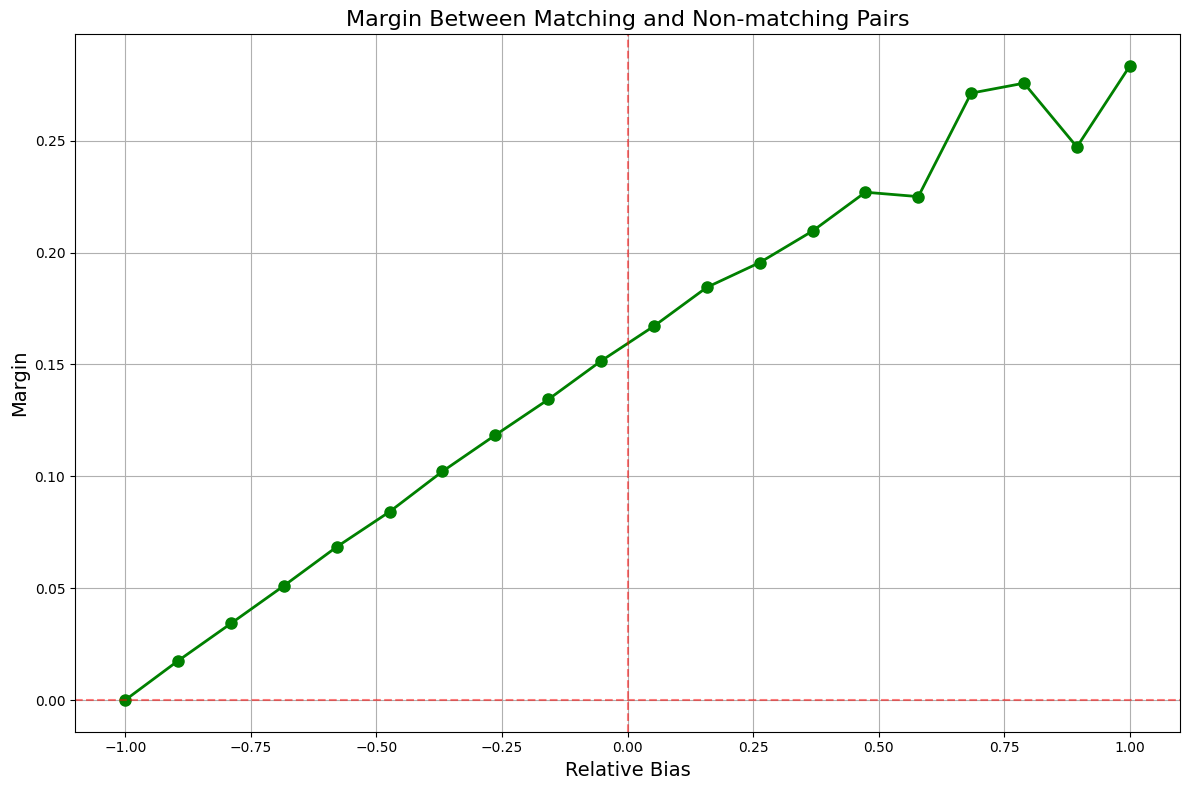

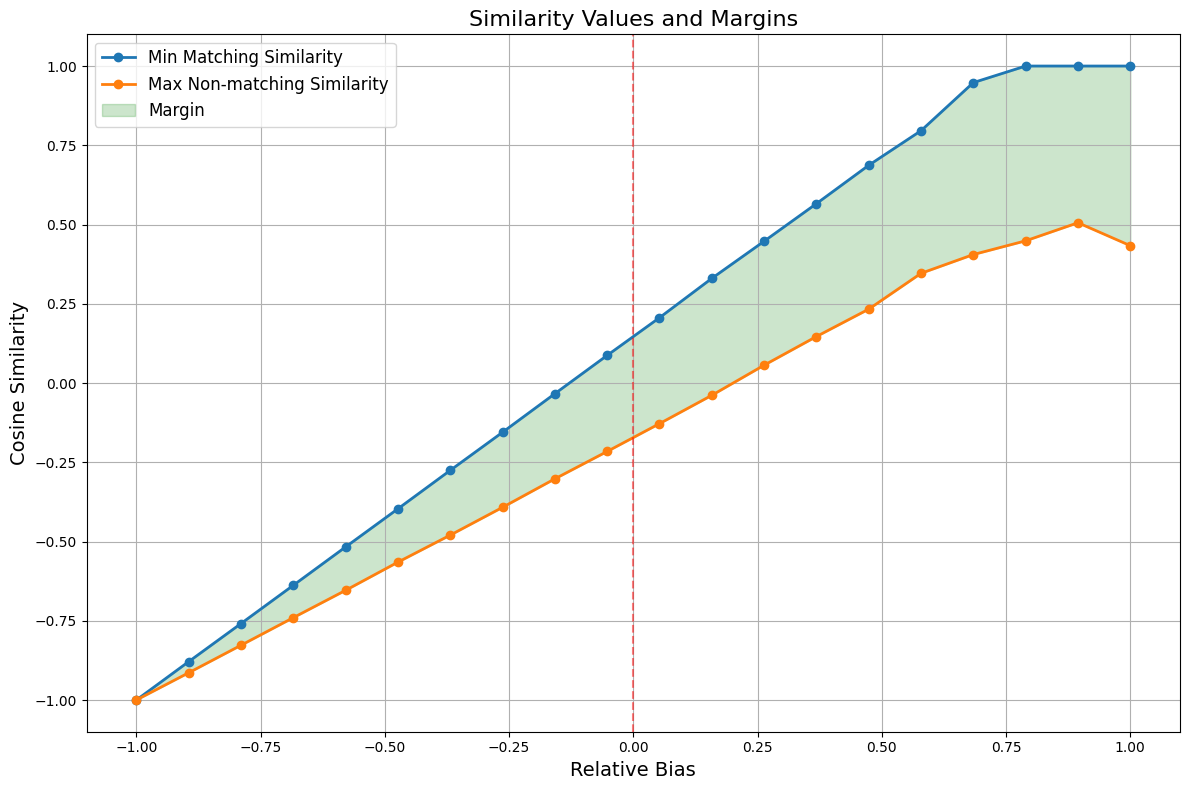

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

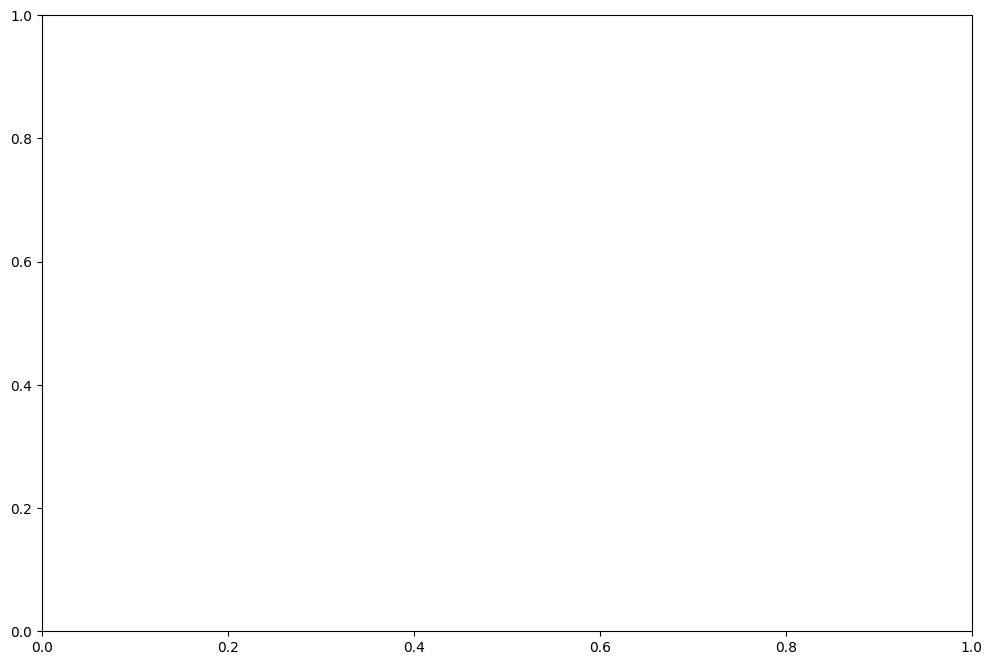

In [25]:
def main():
    # Experiment parameters
    relative_biases = np.linspace(-1.0, 1.0, 20)  # 20 values from -1 to 1
    n_classes = 100
    dim = 10  # Increased dimension to 10
    n_epochs = int(1e4)  # Reduced epochs to 10,000
    
    print(f"Running experiments with relative biases: {relative_biases}")
    
    # Store results for each experiment
    all_results = []
    
    # Run experiments for each relative bias
    for rb in relative_biases:
        U, V, criterion, losses = train_siglip(rb, n_classes, dim, n_epochs)
        all_results.append((U, V, criterion, losses))
    
    # Only analyze and plot margins
    analyze_margins_only(all_results, relative_biases)

def analyze_margins_only(all_results, relative_biases):
    """Analyze and plot only the margins"""
    margins = []
    min_matching_sims = []
    max_non_matching_sims = []
    final_temps = []
    
    for U, V, criterion, _ in all_results:
        # Calculate margin
        margin, min_match, max_non_match = calculate_margin(U, V)
        margins.append(margin)
        min_matching_sims.append(min_match)
        max_non_matching_sims.append(max_non_match)
        final_temps.append(criterion.get_temperature())
    
    # Plot margins
    plt.figure(figsize=(12, 8))
    plt.plot(relative_biases, margins, 'o-', linewidth=2, color='green', markersize=8)
    plt.xlabel('Relative Bias', fontsize=14)
    plt.ylabel('Margin', fontsize=14)
    plt.title('Margin Between Matching and Non-matching Pairs', fontsize=16)
    plt.grid(True)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)  # Add horizontal line at y=0
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)  # Add vertical line at x=0
    plt.tight_layout()
    plt.savefig('siglip_margins.png', dpi=300)
    plt.show()
    
    # Plot similarity values
    plt.figure(figsize=(12, 8))
    plt.plot(relative_biases, min_matching_sims, 'o-', linewidth=2, label='Min Matching Similarity', markersize=6)
    plt.plot(relative_biases, max_non_matching_sims, 'o-', linewidth=2, label='Max Non-matching Similarity', markersize=6)
    plt.fill_between(relative_biases, min_matching_sims, max_non_matching_sims, alpha=0.2, color='green', label='Margin')
    plt.xlabel('Relative Bias', fontsize=14)
    plt.ylabel('Cosine Similarity', fontsize=14)
    plt.title('Similarity Values and Margins', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)  # Add vertical line at x=0
    plt.tight_layout()
    plt.savefig('siglip_similarities.png', dpi=300)
    plt.show()
    
    # Plot temperatures
    plt.figure(figsize=(12, 8))
    plt.plot(relative_biases, final_temps, 'o-', linewidth=2, color='purple', markersize=8)
    plt.xlabel('Relative Bias', fontsize=14)
    plt.ylabel('Final Temperature', fontsize=14)
    plt.title('Final Temperature vs Relative Bias', fontsize=16)
    plt.grid(True)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)  # Add vertical line at x=0
    plt.tight_layout()
    plt.savefig('siglip_temperatures.png', dpi=300)
    plt.show()
    
    # Find the relative bias that produced the maximum margin
    max_margin_idx = np.argmax(margins)
    max_margin_rb = relative_biases[max_margin_idx]
    max_margin_value = margins[max_margin_idx]
    
    # Print the results in a table format
    print("\n=== Margin Analysis Results ===")
    print(f"{'Relative Bias':<15} {'Margin':<10} {'Min Match Sim':<15} {'Max Non-match Sim':<15} {'Temperature':<10}")
    print("-" * 70)
    for rb, margin, min_match, max_non_match, temp in zip(
        relative_biases, margins, min_matching_sims, max_non_matching_sims, final_temps
    ):
        print(f"{rb:<15.3f} {margin:<10.4f} {min_match:<15.4f} {max_non_match:<15.4f} {temp:<10.4f}")
    
    print("\n=== Summary ===")
    print(f"Maximum margin: {max_margin_value:.4f} at relative bias = {max_margin_rb:.3f}")
    
    # Create a CSV with the results
    import csv
    with open('siglip_margin_results.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Relative Bias', 'Margin', 'Min Match Sim', 'Max Non-match Sim', 'Temperature'])
        for rb, margin, min_match, max_non_match, temp in zip(
            relative_biases, margins, min_matching_sims, max_non_matching_sims, final_temps
        ):
            writer.writerow([rb, margin, min_match, max_non_match, temp])
    
    print(f"\nResults saved to siglip_margin_results.csv")

if __name__ == "__main__":
    main()